---

# Load the data

In [53]:
import pandas as pd
import numpy as np

In [54]:
classesDF  = pd.read_csv('../../../data/elliptic_txs_classes.csv')

# Remove all nodes that have unknown class
classesDF = classesDF[classesDF['class'] != "unknown"]

# If class = 2, then map to 0, else map to 1
classesDF['class'] = classesDF['class'].map({'2': 0, '1': 1})

classesDF.head(5)

,txId,class
3,232438397,0
9,232029206,0
10,232344069,0
11,27553029,0
16,3881097,0


In [55]:
featuresDF = pd.read_csv('../../../data/elliptic_txs_features.csv')

# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]

# Remove all edges that do not appear in classesDF
featuresDF = featuresDF[featuresDF['txId'].isin(classesDF['txId'])]

featuresDF.head(5)

,txId,timestep,f0,f1,f2,f3,f4,f5,f6,f7,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
8,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
9,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
10,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
15,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [56]:
# Append the class to the featuresDF based on txID
featuresDF = featuresDF.merge(classesDF, on='txId')

# Move features 'class' to first column
cols = list(featuresDF.columns)
cols = cols[:1] + [cols[-1]] + cols[1:-1]
featuresDF = featuresDF[cols]

featuresDF.head(5)

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


---

# Create the dataset class

In [57]:
import torch
from torch.utils.data import Dataset

In [58]:
class Data(Dataset):
    def __init__(self, data):
        self.data = data
        self.features = self.data.columns[2:]
        self.vectors = self.data[self.features]
        self.vectors = torch.tensor(self.data[self.features].values, dtype=torch.float32)

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, idx):
        return self.vectors[idx]

### Load the data into the dataset class

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

licitSamples = featuresDF[featuresDF['class'] == 0]
illicitSamples = featuresDF[featuresDF['class'] == 1]

# Obtain the needed samples to balance the dataset
AE_data = licitSamples.sample(n=len(licitSamples) - len(illicitSamples), random_state=42)

# Normalize the data
scaler = StandardScaler()
scaler.fit(AE_data.iloc[:, 2:])
AE_data.iloc[:, 2:] = scaler.transform(AE_data.iloc[:, 2:])

# Store licitSamples in a csv file
AE_data.to_csv('../../../data/noPCA_AEData2.csv', index=False)

In [60]:
trainAE, valAE = train_test_split(AE_data, test_size=0.15, random_state=42)

train_dataset = Data(trainAE)
val_dataset = Data(valAE)

print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')

Train size: 31852
Validation size: 5622


### Load the datasets into Dataloaders

In [61]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=True)

---

# Create the model class

In [62]:
import torch.nn as nn

In [63]:
# Create autoencoder for input vectors of size 65

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(166, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 86),
            nn.LeakyReLU(),
            nn.Linear(86, 48),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(48, 86),
            nn.LeakyReLU(),
            nn.Linear(86, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 166),
            nn.LeakyReLU() 
        )
    
    def forward(self, in_features):
        encoded_features = self.encoder(in_features)
        out = self.decoder(encoded_features)
        return out

---

# Create the train and validate functions

In [64]:
import matplotlib.pyplot as plt
# from tqdm import tqdm

### Create train function

In [65]:
def train(model, criterion, optimizer, train_loader, device):
    model.to(device)
    model.train()
    train_loss = 0

    for batch_features in train_loader:
        batch_features = batch_features.view(-1, 166).to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

### Create validate function

In [66]:
def validate(model, criterion, val_loader, device):
    model.to(device)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features in val_loader:
            batch_features = batch_features.view(-1, 166).to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item()*10
    return val_loss

### Create function to do both

In [67]:
def train_and_val(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs, device='cuda', name='AE_loss'):
    losses = []
    for epoch in range(1, epochs+1):
        train_loss = train(model, criterion, optimizer, train_loader, device)
        val_loss = validate(model, criterion, val_loader, device)
        scheduler.step()
        if epoch%100==0:
            print(f'Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {val_loss}\n')
            losses.append([train_loss, val_loss])
    # plot the evolving loss
    plt.figure(figsize=(12, 8))
    plt.plot([i[0] for i in losses], label='Training Loss')
    plt.plot([i[1] for i in losses], label='Validation Loss')
    plt.legend()
    plt.savefig('models/' + str(name) + '.png')
    plt.show()
    return losses

---

# Train small sample of model

Epoch: 100, Training Loss: 2.7040503174066544, Validation Loss: 5.20106241106987

Epoch: 200, Training Loss: 1.651355691254139, Validation Loss: 3.2480723410844803

Epoch: 300, Training Loss: 1.0665084421634674, Validation Loss: 2.2026266902685165

Epoch: 400, Training Loss: 0.936445701867342, Validation Loss: 1.9029748439788818

Epoch: 500, Training Loss: 0.715223602950573, Validation Loss: 1.5621094033122063

Epoch: 600, Training Loss: 0.6046817824244499, Validation Loss: 1.3669434189796448

Epoch: 700, Training Loss: 0.5420140940696001, Validation Loss: 1.2303133681416512

Epoch: 800, Training Loss: 0.5829703416675329, Validation Loss: 1.1162431165575981

Epoch: 900, Training Loss: 0.5304059255868196, Validation Loss: 1.1477259919047356

Epoch: 1000, Training Loss: 0.4237554371356964, Validation Loss: 1.0140770301222801

Epoch: 1100, Training Loss: 0.3601890280842781, Validation Loss: 0.8650387451052666

Epoch: 1200, Training Loss: 0.3503432907164097, Validation Loss: 0.843940842896

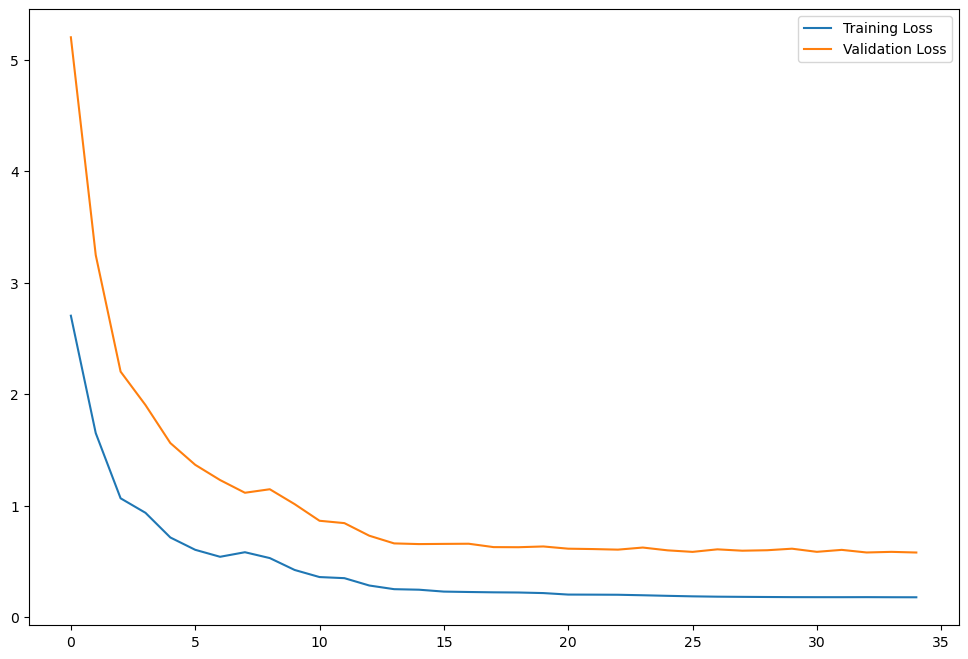

In [68]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
losses = train_and_val(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=3500, device=device, name='noPCA_Autoencoder_secondRUN')

# Save the model
torch.save(model.state_dict(), 'models/NoPCA_Autoencoder_secondRUN.pth')